In [1]:
import numpy as np
import transformers, datasets, torch

print("numpy:", np.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("torch:", torch.__version__)
print("mps available:", torch.backends.mps.is_available())


/Users/rajesh/anaconda3/envs/finetune-llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy: 1.26.4
transformers: 5.1.0
datasets: 4.5.0
torch: 2.10.0
mps available: True


## Imports

In [2]:
import os, random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)
import matplotlib.pyplot as plt


## Seed + device

In [3]:
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)


Device: mps


## Loading dataset

In [4]:
DATA_PATH = "all-data.csv"  # keep file in same folder as notebook

df = pd.read_csv(
    DATA_PATH,
    encoding="latin-1",
    header=None,
    names=["sentiment", "sentence"]
)

print("Shape:", df.shape)
df.head()


Shape: (4846, 2)


,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## Basic profiling + cleanup

Label distribution:
 sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

Duplicates (sentence+sentiment): 6

Sentence length stats (words):
count    4846.000000
mean       23.101114
std         9.958474
min         2.000000
25%        16.000000
50%        21.000000
75%        29.000000
max        81.000000
Name: n_words, dtype: float64


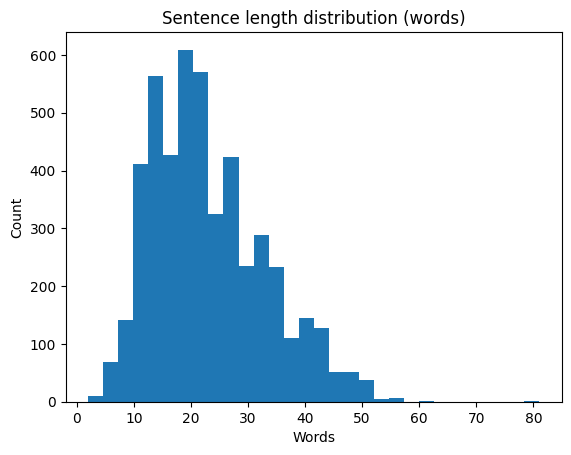

In [5]:
df["sentiment"] = df["sentiment"].astype(str).str.strip().str.lower()
df["sentence"] = df["sentence"].astype(str).str.strip()

# drop empty rows
df = df[(df["sentiment"] != "") & (df["sentence"] != "")].copy()

# show label counts
print("Label distribution:\n", df["sentiment"].value_counts())

# duplicates count
print("\nDuplicates (sentence+sentiment):", df.duplicated(["sentiment","sentence"]).sum())

# length stats
df["n_words"] = df["sentence"].str.split().apply(len)
print("\nSentence length stats (words):")
print(df["n_words"].describe())

plt.figure()
plt.hist(df["n_words"], bins=30)
plt.title("Sentence length distribution (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()


## Encode labels

In [6]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}

df = df[df["sentiment"].isin(label2id.keys())].copy()
df["label"] = df["sentiment"].map(label2id)

df[["sentiment","label"]].drop_duplicates().sort_values("label")


,sentiment,label
2,negative,0
0,neutral,1
3,positive,2


## Train/Val/Test split (70/15/15) stratified

In [7]:
train_df, temp_df = train_test_split(
    df[["sentence","label"]],
    test_size=0.30,
    random_state=SEED,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_df["label"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Train: (3392, 2) Val: (727, 2) Test: (727, 2)


## Convert to HuggingFace Dataset

In [8]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

dataset = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
dataset


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3392
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 727
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 727
    })
})

## Tokenize

In [9]:
MODEL_NAME = "distilbert-base-uncased"  # best for Mac M2 8GB

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=128)

tokenized = dataset.map(tokenize_batch, batched=True, remove_columns=["sentence"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized


Map: 100%|██████████████████████████| 727/727 [00:00<00:00, 62046.17 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3392
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 727
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 727
    })
})

## Metrics

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1}


## Baseline (before fine-tuning)

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

baseline_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

baseline_args = TrainingArguments(
    output_dir="baseline_out",
    per_device_eval_batch_size=16,
    report_to="none"
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

baseline_trainer.evaluate(tokenized["test"])


Loading weights: 100%|█| 100/100 [00:00<00:00, 2310.24it/s, Materializing param=
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/Users/rajesh/anaconda3/envs/finetune-llm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as t

{'eval_loss': 1.101843237876892,
 'eval_model_preparation_time': 0.0006,
 'eval_accuracy': 0.32599724896836313,
 'eval_f1_macro': 0.3107300689620145,
 'eval_runtime': 3.1984,
 'eval_samples_per_second': 227.299,
 'eval_steps_per_second': 14.382}

## Fine-tuning

In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

train_args = TrainingArguments(
    output_dir="fin_sentiment_distilbert",
    eval_strategy="epoch",      # <-- NEW in transformers v5
    save_strategy="epoch",
    save_total_limit=2,
    logging_steps=50,

    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",

    dataloader_pin_memory=False  # avoids MPS pin_memory warning
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Loading weights: 100%|█| 100/100 [00:00<00:00, 1709.40it/s, Materializing param=
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.398162,0.442462,0.833563,0.801828
2,0.228761,0.507216,0.830812,0.812266
3,0.165010,0.607573,0.834938,0.814305


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  1.72it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=1272, training_loss=0.3273854922948393, metrics={'train_runtime': 186.696, 'train_samples_per_second': 54.506, 'train_steps_per_second': 6.813, 'total_flos': 137954837066400.0, 'train_loss': 0.3273854922948393, 'epoch': 3.0})

## Test evaluation + confusion matrix

{'eval_loss': 0.6020410656929016, 'eval_accuracy': 0.8514442916093535, 'eval_f1_macro': 0.8363529582066711, 'eval_runtime': 2.5894, 'eval_samples_per_second': 280.761, 'eval_steps_per_second': 17.765, 'epoch': 3.0}

Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.90      0.82        91
     neutral       0.89      0.87      0.88       432
    positive       0.81      0.80      0.80       204

    accuracy                           0.85       727
   macro avg       0.82      0.86      0.84       727
weighted avg       0.85      0.85      0.85       727


Confusion Matrix:
 [[ 82   6   3]
 [ 23 374  35]
 [  3  38 163]]


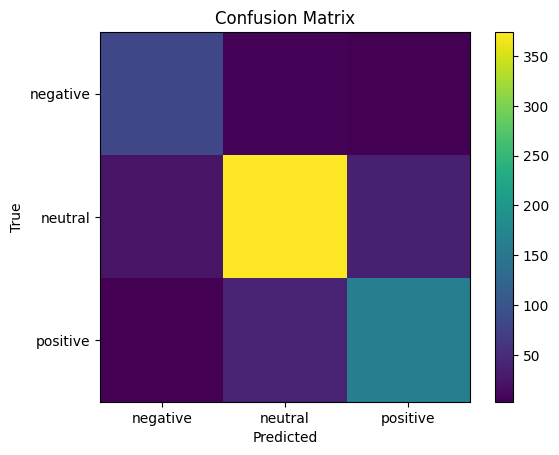

In [13]:
test_metrics = trainer.evaluate(tokenized["test"])
print(test_metrics)

pred_out = trainer.predict(tokenized["test"])
logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = np.argmax(logits, axis=-1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(3)]))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1,2], [id2label[i] for i in range(3)])
plt.yticks([0,1,2], [id2label[i] for i in range(3)])
plt.colorbar()
plt.show()


## Hyperparameter tuning (3 configs)

In [14]:
import gc, os
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Force CPU for tuning to avoid MPS OOM
# (we keep MPS for the final training later)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

def clear_all():
    gc.collect()
    if torch.backends.mps.is_available():
        try:
            torch.mps.empty_cache()
        except:
            pass

# Smaller max length reduces memory + speeds up CPU
MAX_LEN = 96

def tokenize_batch_short(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=MAX_LEN)

tokenized_small = dataset.map(tokenize_batch_short, batched=True, remove_columns=["sentence"])

configs = [
    {"lr": 2e-5, "bs": 8, "wd": 0.01, "epochs": 3},
    {"lr": 3e-5, "bs": 8, "wd": 0.00, "epochs": 3},
    {"lr": 1e-5, "bs": 8, "wd": 0.01, "epochs": 2},  # fewer epochs for speed, still valid config
]

tuning_results = []

for i, cfg in enumerate(configs, start=1):
    print(f"\n===== RUN {i} / {len(configs)} : {cfg} =====")
    clear_all()

    model_i = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
    )

    args_i = TrainingArguments(
        output_dir=f"tuning_run_{i}",
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        num_train_epochs=cfg["epochs"],
        learning_rate=cfg["lr"],
        per_device_train_batch_size=cfg["bs"],
        per_device_eval_batch_size=8,
        weight_decay=cfg["wd"],
        report_to="none",
        dataloader_pin_memory=False,

        use_cpu=True,  # ✅ KEY LINE: keeps tuning off MPS
    )

    trainer_i = Trainer(
        model=model_i,
        args=args_i,
        train_dataset=tokenized_small["train"],
        eval_dataset=tokenized_small["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer_i.train()

    val_metrics = trainer_i.evaluate(tokenized_small["validation"])
    test_metrics = trainer_i.evaluate(tokenized_small["test"])

    tuning_results.append({
        "run": i,
        "lr": cfg["lr"],
        "batch_size": cfg["bs"],
        "weight_decay": cfg["wd"],
        "epochs": cfg["epochs"],
        "val_accuracy": val_metrics["eval_accuracy"],
        "val_f1_macro": val_metrics["eval_f1_macro"],
        "test_accuracy": test_metrics["eval_accuracy"],
        "test_f1_macro": test_metrics["eval_f1_macro"],
    })

results_df = pd.DataFrame(tuning_results).sort_values("val_f1_macro", ascending=False)
results_df


Map: 100%|██████████████████████████| 727/727 [00:00<00:00, 53924.33 examples/s]



===== RUN 1 / 3 : {'lr': 2e-05, 'bs': 8, 'wd': 0.01, 'epochs': 3} =====


Loading weights: 100%|█| 100/100 [00:00<00:00, 925.21it/s, Materializing param=d
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.407960,0.487134,0.818432,0.780371
2,0.262261,0.496313,0.819807,0.799816
3,0.163447,0.578133,0.847318,0.823922



===== RUN 2 / 3 : {'lr': 3e-05, 'bs': 8, 'wd': 0.0, 'epochs': 3} =====


Loading weights: 100%|█| 100/100 [00:00<00:00, 1747.03it/s, Materializing param=
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.387895,0.506039,0.825309,0.791317
2,0.242251,0.562934,0.833563,0.818993
3,0.131539,0.685839,0.837689,0.820106



===== RUN 3 / 3 : {'lr': 1e-05, 'bs': 8, 'wd': 0.01, 'epochs': 2} =====


Loading weights: 100%|█| 100/100 [00:00<00:00, 1066.95it/s, Materializing param=
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.459788,0.467932,0.806052,0.757654
2,0.324215,0.431314,0.823934,0.797697


,run,lr,batch_size,weight_decay,epochs,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro
0,1,0.00002,8,0.01,3,0.847318,0.823922,0.850069,0.834346
1,2,0.00003,8,0.00,3,0.837689,0.820106,0.852820,0.840135
2,3,0.00001,8,0.01,2,0.823934,0.797697,0.836314,0.815041


## Set best hyperparameters

In [15]:
best_lr = 2e-5
best_bs = 8
best_wd = 0.01
best_epochs = 3

print(best_lr, best_bs, best_wd, best_epochs)

2e-05 8 0.01 3


## Train FINAL model on MPS (fast) using best config

In [16]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

final_args = TrainingArguments(
    output_dir="FINAL_MODEL",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_steps=50,

    num_train_epochs=best_epochs,
    learning_rate=best_lr,
    per_device_train_batch_size=best_bs,
    per_device_eval_batch_size=16,
    weight_decay=best_wd,

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    dataloader_pin_memory=False
)

final_trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

final_trainer.train()


Loading weights: 100%|█| 100/100 [00:00<00:00, 1806.43it/s, Materializing param=
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.393642,0.450350,0.822558,0.790425
2,0.216156,0.553142,0.830812,0.811375
3,0.180637,0.618900,0.837689,0.815343


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  1.37it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=1272, training_loss=0.334573192791369, metrics={'train_runtime': 200.8435, 'train_samples_per_second': 50.666, 'train_steps_per_second': 6.333, 'total_flos': 137954837066400.0, 'train_loss': 0.334573192791369, 'epoch': 3.0})

## Final TEST evaluation + confusion matrix

{'eval_loss': 0.5761260986328125, 'eval_accuracy': 0.8541953232462174, 'eval_f1_macro': 0.8390690967302822, 'eval_runtime': 2.9283, 'eval_samples_per_second': 248.266, 'eval_steps_per_second': 15.709, 'epoch': 3.0}

Classification Report:

              precision    recall  f1-score   support

    negative       0.74      0.92      0.82        91
     neutral       0.90      0.86      0.88       432
    positive       0.82      0.80      0.81       204

    accuracy                           0.85       727
   macro avg       0.82      0.86      0.84       727
weighted avg       0.86      0.85      0.85       727


Confusion Matrix:
 [[ 84   5   2]
 [ 25 373  34]
 [  4  36 164]]


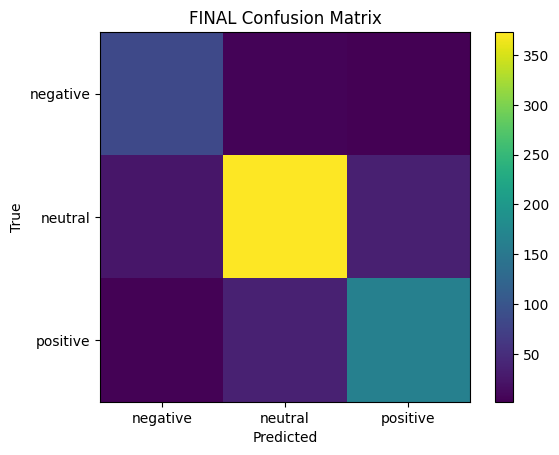

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

final_test_metrics = final_trainer.evaluate(tokenized["test"])
print(final_test_metrics)

pred_out = final_trainer.predict(tokenized["test"])
logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = np.argmax(logits, axis=-1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(3)]))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure()
plt.imshow(cm)
plt.title("FINAL Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1,2], [id2label[i] for i in range(3)])
plt.yticks([0,1,2], [id2label[i] for i in range(3)])
plt.colorbar()
plt.show()


## Error analysis (misclassified examples + confidence)

In [18]:
import torch

test_sentences = test_df.reset_index(drop=True)["sentence"].tolist()

probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
wrong_idx = np.where(y_true != y_pred)[0]
print("Total misclassified:", len(wrong_idx))

wrong_conf = [(idx, probs[idx, y_pred[idx]]) for idx in wrong_idx]
wrong_conf = sorted(wrong_conf, key=lambda x: x[1], reverse=True)[:15]

for idx, conf in wrong_conf:
    print("\n---")
    print("TEXT:", test_sentences[idx])
    print("TRUE:", id2label[int(y_true[idx])], "| PRED:", id2label[int(y_pred[idx])], "| CONF:", float(conf))


Total misclassified: 106

---
TEXT: A & euro ; 4.8 million investment in 13.6 % of Lewa netted Deutsche Beteiligungs & euro ; 21 million .
TRUE: positive | PRED: neutral | CONF: 0.9970366954803467

---
TEXT: The shopping center will have a prime location right next to the Myllypuro metro station .
TRUE: positive | PRED: neutral | CONF: 0.9965384006500244

---
TEXT: The terms of the financing were approved by the Annual General Meeting of the Company held on June 30 , 2010 .
TRUE: positive | PRED: neutral | CONF: 0.9964566826820374

---
TEXT: Jobs will not be transferred from Finland , however .
TRUE: positive | PRED: neutral | CONF: 0.9960131645202637

---
TEXT: The circuit 's overall production rate on a weekly basis is now in excess of an average of 40,000 tonnes per day , with volumes in excess of 50,000 tonnes per day being reached on individual days .
TRUE: positive | PRED: neutral | CONF: 0.9959980249404907

---
TEXT: This bold spinning 360 red fabric design is set beautifully on

## Save model + tokenizer

In [19]:
SAVE_DIR = "distilbert_fin_sentiment_final"
final_trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  1.60it/s]

Saved to: distilbert_fin_sentiment_final


## Inference function (for demo/video)

In [20]:
from transformers import pipeline

clf = pipeline(
    "text-classification",
    model=SAVE_DIR,
    tokenizer=SAVE_DIR,
    device=-1
)

def predict_sentiment(text):
    out = clf(text, truncation=True)[0]
    return {"label": out["label"], "score": float(out["score"])}

predict_sentiment("Company reports higher revenue and strong quarterly profits.")


Loading weights: 100%|█| 104/104 [00:00<00:00, 1762.38it/s, Materializing param=


{'label': 'positive', 'score': 0.9931381344795227}